# Finite element solver for plane problem : PyMechanica
## Paramveer Sharma
## IIT Madras 


In [1]:


import numpy as np
import matplotlib.pyplot as plt
nu = 0.3
E = 300 * 10**3
#NodeData = np.array([[1, 0, 0], [2, 0, 10], \
                     #3, 20, 10], [4, 20, 0]])
print('Input file successfully imported')

f2 = open('Elem-1.txt', 'w')
f1 = open('Node-1.txt', 'w')
with open('Job-1.inp') as file:
    for line in file:
        if line[0:5] =='*Node':
           #2 print(line)
            for line in file:
                if line[0:8] !='*Element':
                    f1.write(line)
                    #print(line)
                else:
                    break
            f1.close()
        if line[0:8] =='*Element':
       # if line[0:5] =='*Node':
           # print(line)
            for line in file:
                if line[0:1] !='*':
                    f2.write(line)
                else:
                    break
            f2.close()
        else:
            pass
print('Reading geometry and mesh data!')

Input file successfully imported
Reading geometry and mesh data!


Applying forces on the nodes


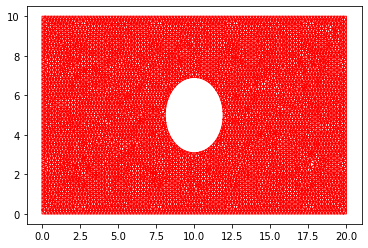

In [2]:
NodeData = np.loadtxt('Node-1.txt', delimiter = ',')
ElemDatawithElemNo = np.loadtxt('Elem-1.txt', delimiter = ',')
ElemData  = ElemDatawithElemNo[:,1:4]
ElemData = ElemData.astype(int)
NodeCoord = NodeData[:, 1:3]

NodeCoord = NodeData[:, 1:3]


def MeshPlot(NodeXYCoord, ConnectMat, lc, ltype):
    fig, ax = plt.subplots()
    noelem, nonode = np.shape(ConnectMat)
    for ii in range(noelem):
        xvec, yvec = np.array([]), np.array([])
        elem = ConnectMat[ii]
        for jj in range(len(elem)):
            xvec = np.append(xvec, NodeXYCoord[elem[jj]-1, 0])
            yvec = np.append(yvec, NodeXYCoord[elem[jj]-1, 1])
        xvec = np.append(xvec, xvec[0])
        yvec = np.append(yvec, yvec[0])

        ax.plot(xvec, yvec, ltype, lw = '1', color = lc, label = 'undeformed') 

nele = len(ElemData)
ndof = 2
nnode = len(NodeData)
elemdof =6
LoadNode = np.zeros([nnode, 2])
rglobal  = np.zeros([nnode*ndof, 1])
kglobal = np.zeros([nnode*ndof,nnode*ndof])
print('Applying forces on the nodes')
for i in range(len(NodeCoord)):
    if NodeCoord[i, 0] == 20.0:
        LoadNode[i, 0] =200
MeshPlot(NodeCoord, ElemData, 'red', 1)

In [3]:
def Bmatrix(elabel, ElemData, NodeData):
    elem = ElemData[elabel]
    xi, xj, xm = NodeData[elem[0]-1,1], NodeData[elem[1]-1,1], NodeData[elem[2]-1,1]#, 0, 20, 0
    yi, yj, ym = NodeData[elem[0]-1,2], NodeData[elem[1]-1,2], NodeData[elem[2]-1,2]
    Adet = np.array([[1, xi, yi], [1, xj, yj], [1, xm, ym]])
    A = (1/2)*np.linalg.det(Adet)
    beta_i =  yj-ym 
    beta_j = ym-yi 
    beta_m = yi-yj
    gamma_i = -(xj-xm)
    gamma_j = -(xm-xi)
    gamma_m = -(xi-xj)
    b1 = [beta_i, 0, beta_j, 0, beta_m, 0]
    b2 = [0, gamma_i, 0, gamma_j, 0, gamma_m]
    b3 = [gamma_i, beta_i, gamma_j, beta_j, gamma_m, beta_m]
    Bmat = (1/(2*A))*np.array([b1, b2, b3])
    return Bmat, A

In [4]:
print('Elementwise solution started: Building global force and stiffness matrix')
for el in range(nele):
    elem = ElemData[el]
    #xi, xj, xm = NodeData[elem[0]-1,1], NodeData[elem[1]-1,1], NodeData[elem[2]-1,1]#, 0, 20, 0
    #yi, yj, ym = NodeData[elem[0]-1,2], NodeData[elem[1]-1,2], NodeData[elem[2]-1,2]
    #beta_i =  yj-ym 
    #beta_j = ym-yi 
    #beta_m = yi-yj
    #gamma_i = -(xj-xm)
    #gamma_j = -(xm-xi)
    #gamma_m = -(xi-xj)
    #b1 = [beta_i, 0, beta_j, 0, beta_m, 0]
    #b2 = [0, gamma_i, 0, gamma_j, 0, gamma_m]
    #b3 = [gamma_i, beta_i, gamma_j, beta_j, gamma_m, beta_m]

    B, A = Bmatrix(el, ElemData, NodeData)

    D = E/(1-nu**2)*np.array([[1, nu, 0],[nu, 1, 0],[0, 0, (1-nu)/2]])
    tempM = np.dot(np.transpose(B),D)
#ke = np.array([[2, 3, 4, 3, 1, 8], [2, 4, 6, 7, 8, 1], [1, 23, 34, 4, 7, 9], [3, 4, 6, 7, 8, 9], [3, 5, 7, 8, 9, 3], [7, 9, 10, 24, 12, 6]])
    ke = A*np.dot(tempM,B) #np.array([c1, c2, c3, c4, c5, c6])
    connect = np.repeat(elem, 2)
    r = np.array([2, 1, 2, 1, 2, 1])
    rlocal = list(LoadNode[elem[0]-1,:]) + list(LoadNode[elem[1]-1,:])+ list(LoadNode[elem[2]-1,:])
    #print(rlocal)
    for i in range(0, elemdof):
        #rglobal[(2*connect[i]-r[i]), 0] = rglobal[(2*connect[i]-r[i]), 0] + rlocal[i]
        rglobal[(2*connect[i]-r[i]), 0] =  rlocal[i]
        #print(rglobal)
        #print('\n')
        for j in range(0,elemdof):
            kglobal[(2*connect[i]-r[i]), (2*connect[j]-r[j])] = kglobal[(2*connect[i]-r[i]), (2*connect[j]-r[j])] + \
            ke[i, j]
        #print(kglobal[(2*connect[i]-r[i]), (2*connect[j]-r[j])])
    #print(rglobal)
    #print('\n')
print('Global stiffness matrix successfully created')

Elementwise solution started: Building global force and stiffness matrix
Global stiffness matrix successfully created


In [5]:
DisplacewithBC = np.ones([ndof*nnode,1])
#DisplacewithBC[0:4,0] = 0
#DisplacewithBC[22,0] = 0
#DisplacewithBC[23,0] = 0
print('Applying displacement boundary condition to the constrained node')
for i in range(len(NodeCoord)):
    if NodeCoord[i, 0] == 0.0 and NodeCoord[i, 1] ==0.0:
        DisplacewithBC[2*i, 0] = 0
        DisplacewithBC[2*i+1, 0] = 0
   # if NodeCoord[i, 1] ==0.0:
    #    DisplacewithBC[2*i+1, 0] = 0
    if NodeCoord[i, 0] ==0.0:
        DisplacewithBC[2*i, 0] = 0
  #  if NodeCoord[i, 1] ==10.0:
   #     DisplacewithBC[2*i+1, 0] = 0
kreduced, rreduced = kglobal, rglobal
dcount, rcount, indxnum = 0,0, np.array([])
knownU = np.array([])
print('Displacement boundary condition successfully applied!')

Applying displacement boundary condition to the constrained node
Displacement boundary condition successfully applied!


In [6]:
while dcount <(ndof*nnode):
    if DisplacewithBC[dcount]==0:
        kreduced = np.delete(kreduced, rcount, 0)
        kreduced = np.delete(kreduced, rcount, 1)
        rreduced = np.delete(rreduced, rcount, 0)
        knownU = np.append(knownU, DisplacewithBC[dcount])
        #print(dcount)
    else:
        rcount += 1
        indxnum = np.append(indxnum, dcount)
    dcount+= 1
    
print('Solving for unknown nodal displacements')  
    
KInv = np.linalg.inv(kreduced)
unknownU = np.matmul(KInv,rreduced)
Displacement = DisplacewithBC
print('Solution completed for unknown displacements')
for indx in range(len(indxnum)):
    index = int(indxnum[indx])
    Displacement[index] =unknownU[indx] 

force = np.matmul(kglobal, Displacement)

Solving for unknown nodal displacements
Solution completed for unknown displacements


In [7]:
DeformedCoord = np.zeros([nnode, 2])
print('Obtaining the deformed shape')
for ii in range(nnode):
    DeformedCoord[ii, :] = NodeCoord[ii] + np.array([Displacement[2*ii, 0], Displacement[2*ii+1, 0]])
    
Dispx, forceX = np.array([]), np.array([])
Dispy, forceY = np.array([]), np.array([])
for i in range(nnode):
    Dispx = np.append(Dispx, Displacement[2*i])
    Dispy = np.append(Dispy, Displacement[2*i+1])
    forceX = np.append(forceX, force[2*i])
    forceY = np.append(forceY, force[2*i+1])
print('Calculating stress-strain response from displacement!')
strain, stress = np.zeros([nele, 3]), np.zeros([nele, 3])
for e in range(len(ElemData)):
    enum = ElemData[e]-1
   # elemDisp = [enum[0], enum[1], enum[2]]   
    B, Area = Bmatrix(e, ElemData, NodeData)     
    uarray = np.transpose(np.array([Dispx[enum[0]], Dispy[enum[0]],\
                                      Dispx[enum[1]], Dispy[enum[1]],\
                                      Dispx[enum[2]], Dispy[enum[2]]]))
    strain[e, :] = np.matmul(B, uarray)   
    stress[e] = np.matmul(D, strain[e, :])
print('Analysis successfully completed!')

Obtaining the deformed shape
Calculating stress-strain response from displacement!
Analysis successfully completed!


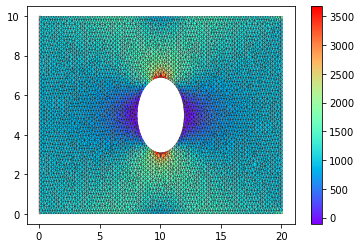

In [9]:
# Plotting the deformed geometry  

#MeshPlot(NodeCoord, ElemData, 'red', '-')
#MeshPlot(DeformedCoord, ElemData, 'blue', '--')
#fig, ax = plt.subplots()
#xcoord = NodeCoord[:,0]
#ycoord = NodeCoord[:,1]
#contr1 = plt.triplot(NodeCoord[:,0], NodeCoord[:,1], ElemData-1,\
 #          'k-',lw = 0.5)
contr = plt.tripcolor(DeformedCoord[:,0], DeformedCoord[:,1], ElemData-1, stress[:, 0],\
          edgecolors='k',cmap='rainbow' )
#contr = plt.tripcolor(DeformedCoord[:,0], DeformedCoord[:,1], ElemData-1, Dispx, shading='gouraud')
#contr = ax.triplot(DeformedCoord[:,0], DeformedCoord[:,1], ElemData-1, 'r-', lw = 1 )
#contr = plt.tricontourf(DeformedCoord[:,0], DeformedCoord[:,1], ElemData-1, Dispx, 20, cmap='rainbow' )
plt.colorbar()
    
    